In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import re
import string
from pandas_summary import DataFrameSummary
import pickle
from tqdm import tqdm_notebook

%load_ext autoreload
%autoreload 2
%matplotlib inline

pd.options.display.max_colwidth = 300
pd.options.display.max_columns = 30
pd.options.display.max_rows = 5000
seed = 42
np.random.seed(seed)

# Constants

In [3]:
# Target column name
TARGET_COLUMN = 'ProductCategoryLevel3UNSPSCCode'
data_path = '../data/'

# Read each file and concat

In [4]:
files = os.listdir('../data')
reg_pat = r'^ProductInfo_201[0-9]+\.csv$'
concat_files = []
for file in files:
    m = re.match(reg_pat, file)
    if m:
        concat_files.append(file)

In [5]:
df_full = pd.read_csv(data_path + concat_files[0], sep=";", encoding='latin1', error_bad_lines=False)

In [6]:
for i in range(1, len(concat_files)):
    df_full = pd.concat([df_full, pd.read_csv(data_path + concat_files[i], sep=";", encoding='latin1', error_bad_lines=False)])

C:\Users\BJOVAS\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (16,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\BJOVAS\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
b'Skipping line 476610: expected 30 fields, saw 36\n'
C:\Users\BJOVAS\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (14,16,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
sumdf = DataFrameSummary(df_full).summary()
sumdf

,ProductCategoryLevel3UNSPSCCode,ProductCategoryLevel3Name,ProductCategoryLevel4UNSPSCCode,ProductCategoryLevel4Name,BuyerOrgLevel1,BuyerOrgLevel2,BuyerOrgLevel3,VendorName,VendorId,VendorTPID,CatalogueID,ShipToCompanyCode,ShipToCompanyName,ShipToAddress,ShipToAddressZipCode,ShipToCity,Contract,ProductName,VendorPartNumber,ClassificationCode,ClassificationName,UnitOfMeasure,CurrencyCode,Quantity,UnitPrice,ProcessType,OrderDateKey,OrderId,Manufacturer,ManufacturerProductNo
count,4.98819e+06,NaN,4.98819e+06,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.52936e+07,NaN,3.52936e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.32543e+07,NaN,2.32543e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-1,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.11218e+07,NaN,1.11218e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4.41031e+07,NaN,4.41031e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,5.01819e+07,NaN,5.01819e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,1e+08,NaN,1e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
counts,4988192,4988192,4988192,4988192,0,4988192,4988057,4988153,4902716,4988192,4000304,4691620,4988192,4906178,4947940,4951468,112073,4988042,4848730,32719,32719,4988192,4988192,4988192,4988192,4988192,4988192,4988192,3041525,2313689
uniques,1283,1319,4942,4968,0,294,4796,12900,5725,521,2603,21342,28942,20744,3839,1217,168,608586,375314,61,61,90,17,1491,129729,3,365,906562,5706,79543


## Remove rows with missing product name or an unspsc code of -1 or 99999999 (invalid/missing)

In [8]:
df_full = df_full.dropna(subset=['ProductName'])
df_full = df_full[df_full[TARGET_COLUMN] != -1]
df_full = df_full[df_full[TARGET_COLUMN] != 99999999]
df_full.reset_index(inplace=True, drop=True)
df_full.shape

(3713327, 30)

## Remove lines with no 3. level code

In [9]:
#get the level 3. code through calculation in order to utilize vectorized speedups (instead of string extraction)
df_full_code3 = df_full[TARGET_COLUMN].astype('int32')//100 - (df_full[TARGET_COLUMN].astype('int32')//10000)*100
df_full = df_full[df_full_code3 != 0]
df_full.shape

(3297810, 30)

## Remove product names that are just numbers

In [10]:
num_pattern = r'^[0-9]*((\.|\,)?[0-9]*)*$'
is_num = []
for product_name in df_full['ProductName'].values:
    m = re.match(num_pattern, product_name)
    is_num.append(not bool(m))
df_full = df_full.loc[is_num]
df_full.shape

(3297735, 30)

In [11]:
sumdf = DataFrameSummary(df_full).summary()
sumdf

,ProductCategoryLevel3UNSPSCCode,ProductCategoryLevel3Name,ProductCategoryLevel4UNSPSCCode,ProductCategoryLevel4Name,BuyerOrgLevel1,BuyerOrgLevel2,BuyerOrgLevel3,VendorName,VendorId,VendorTPID,CatalogueID,ShipToCompanyCode,ShipToCompanyName,ShipToAddress,ShipToAddressZipCode,ShipToCity,Contract,ProductName,VendorPartNumber,ClassificationCode,ClassificationName,UnitOfMeasure,CurrencyCode,Quantity,UnitPrice,ProcessType,OrderDateKey,OrderId,Manufacturer,ManufacturerProductNo
count,3.29774e+06,NaN,3.29774e+06,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.60814e+07,NaN,4.60814e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.25326e+07,NaN,1.25326e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.01015e+07,NaN,1.01015e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,4.22916e+07,NaN,4.22916e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4.71318e+07,NaN,4.71318e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,5.01927e+07,NaN,5.01927e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,9.51417e+07,NaN,9.51417e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
counts,3297735,3297735,3297735,3297735,0,3297735,3297693,3297710,3238434,3297735,2484890,3204229,3297735,3264934,3288555,3294206,110558,3297735,3296909,32270,32270,3297735,3297735,3297735,3297735,3297735,3297735,3297735,2385474,1940814
uniques,1114,1145,4773,4798,0,288,4574,1471,3345,415,2520,18331,22132,17043,3384,1072,164,221234,193668,60,60,65,6,798,83449,3,365,538359,4748,63805


# Add a new column named Label containing the code of the target level in UNSPSC

In [12]:
df_full['Label'] = df_full[TARGET_COLUMN].astype('int32')//100

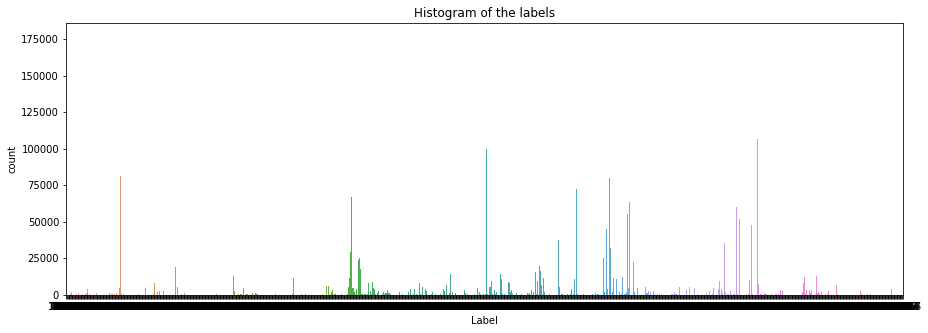

In [13]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x="Label", data=df_full)
ax.set_title('Histogram of the labels')
plt.show()

In [14]:
df_full.sample(10).loc[:, ['ProductCategoryLevel3Name', 'ProductCategoryLevel4Name', 'ProductName']]

,ProductCategoryLevel3Name,ProductCategoryLevel4Name,ProductName
923899,Cleaning and disinfecting solutions,Dishwashing products,DEKONTAMINATORMIDDEL DEKOREN+ TØRR 5.5KG (STYKK Á 1 STYKK Á 1)
1741052,Labeling machines,Automatic labeling systems,LABELMANAGER DYMO 160 QWERTY
3623350,Computer accessories,Computer accessories,APPLE APPLE USB-C TO USB ADAPTER
652595,Personal paper products,Toilet tissue,TOARLL MINI JUMBO 2LAG 170M T2
3534334,Printed publications,Educational or vocational textbooks,MULTI 3 2. UTGAVE : OPPGAVEBOK : MATEMATIKK FOR BARNETRINNET BOKMÅL H
1796569,Writing instruments,Wooden pencils,( PK AV 12) BLYANT HB
925333,Non alcoholic beverages,Fresh juice,SUNNIVA ORIG EPLE BIB SLIM 10L
372490,Fruits,Fresh fruit,EPLER ROYAL GALA KG
2960539,Confectionary products,Chocolate or chocolate substitute candy,TWIST MINI MIX 1 5KG
1809904,Safety apparel,Safety apparel,SKALLBUKSE 1260 SVART M


## Remove unused columns, cast data in VendorName to string

In [15]:
df = df_full.loc[:, ['ProductName', 'Label', 'VendorName']]
df['VendorName'] = df['VendorName'].astype('str')

## Save dataframe to pickle

In [14]:
df_full.to_pickle(data_path + '2017-2018.pkl')

In [2]:
df_full = pd.read_pickle(data_path + '2017-2018.pkl')
df_full

,ProductName,Label
0,HOBBYFILT 45 CM X 5 METER. HVIT.,111621
35,EPLEJUICE 1 5L ELDORADO,502023
41,TILBUDSMAPPE LYRECO BUDGET PP A4 SORT,441220
42,TILBUDSMAPPE LYRECO BUDGET PP A4 GUL BLÅ,441220
43,TILBUDSMAPPE LYRECO BUDGET PP A4 RØD,441220
44,TILBUDSMAPPE LYRECO BUDGET PP A4 GRØNN,441220
45,HIGHLIGHTER LYRECO BUDGET GUL,441217
46,HIGHLIGHTER LYRECO BUDGET PINK,441217
47,HIGHLIGHTER LYRECO BLÅ,441217
48,HIGHLIGHTER LYRECO BUDGET GRØNN,441217
